# Class: STATS 507
Professor: Keith, Levin 

Student: Martin, Zanaj, mzanaj@umich.edu

Homework 8

I have not disclosed my code with no additional individual. 

In [14]:
#Question 1
#1. 
#Write a word counter and ignore punctuation
#Reference: slides & https://mrjob.readthedocs.io/en/latest/guides/writing-mrjobs.html

from mrjob.job import MRJob
import string
import re

#Read all lines 
WORD_RE = re.compile(r"[\w']+")

#Class
class mr_word_count(MRJob):
    #Read each word
    #Strip punctuation
    #Output: (key, value) word, 1
    def mapper(self, _, line):
        #All punctuation symbols 
        punct= string.punctuation
        #Loop in each word of the text 
        for word in WORD_RE.findall(line):
            my_word = str()
            #check each character
            for char in word:
                if(char in punct):
                    #Check if it is hyphen, if so consider them two different words (John's = "John" & "s")
                    if(char == "'"):
                        yield my_word.lower(),1
                    my_word= ''
                    continue
                else:
                    my_word = my_word +char
            #yield lower case
            yield my_word.lower(), 1
    #Key are coming from mapper (each word is a key, value = sum of all 1's that have same key)
    #All words that are identical be added and considered as one
    #I believe we have more than one key, meaning ( john:2, John: 2)
    def combiner(self, word, counts):
        yield word, sum(counts)
    #Reduce all: same key: will be reduced to one key
    def reducer(self, word, counts):
        yield word, sum(counts)
        
#Give control to cmd 
if __name__ == '__main__':
    mr_word_count.run()

#2. 
#CHECK "Local-Cavium-Hadoop Connection Steps.docx" for instructions on how I did this
#Download simple.txt
#open cmd type (run locally):  
# PATH                                               # PYTHON SHELL                       # SAVE OUTPUT
# C:\Users\user\STATS 507 Jupyter Folder\MZANAJ_HW8> python mr_word_count.py simple.txt > simple_word_counts.txt
#check output file (simple_word_counts.txt)
#Success: the code does what it should: tuple (key, value) with proper key and value

#3. 
#CHECK "Local-Cavium-Hadoop Connection Steps.docx" for instructions on how I did this
#for the moment, just write the scripts worry about execution later
#move script to cluster
#               scp mr_word_count mzanaj@cavium ....~/mr_word_count.py
#Log into cluster system (password, DUO confirmation)
#               ssh to mzanaj@cavium-thunderx.arc-ts.umich.edu
#be in home directory (~) & save file with same name, ls to check
#               mr_word_count.py
#Check file contents
#        head mr_word_count.py
#run file & save to 
#        python mr_word_count.py -r hadoop
#        -c /etc/mrjob.conf.stats507
#       hdfs:///var/stats507f19/darwin.txt  
#                                        > darwin_word_counts.txt
#Copy file from cluster to local machine
#      cat darwin_word_counts.txt
#      scp mzanaj@cavium.....~/darwin_word_counts.txt .

#I Used WinScp to copy files from local to cluster, and run command on cavium through putty
#python mr_word_count.py -r hadoop -c /etc/mrjob.conf.stats507 hdfs:///var/stats507f19/darwin.txt > darwin_word_counts.txt


usage: ipykernel_launcher.py [options] [input files]
ipykernel_launcher.py: error: unrecognized arguments: -f


SystemExit: 2

c:\users\user\appdata\local\programs\python\python37-32\lib\site-packages\IPython\core\interactiveshell.py:3334: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


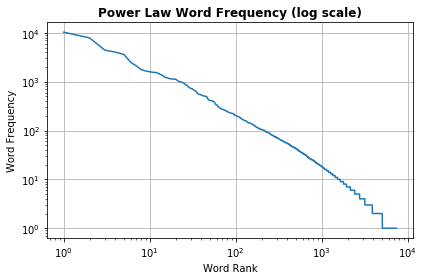

In [84]:
#4.
#Create  a plot of frequency and the words
import numpy as np
import matplotlib as mp
import math
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
%matplotlib inline

#open file & read contents
f = open("./darwin_word_counts.txt")    
p = f.readlines()
#All keys
import re
WORD_RE = re.compile(r"\d+|\w")

x_axis = []
y_axis = []
temp = ""
num = 0
flag = 0
#Extract the data from .txt file
for x in p:
    for y in x:
       
        if(flag==0):
            
            if(y!="\t"):
                continue 
            else:
                #Consider each word as a number  (rank)
                num= num+1
                x_axis.append(num)
                temp= ""
                flag=1
        elif(flag==1):
            if(y!="\n"):
                temp = temp+y
            else:
                y_axis.append(int(temp))
                temp= ""
                flag=0
#Re-arrange in descending order  [the frequencies]
y_axis.sort(reverse = True)

#plot in log scale
plt.plot(x_axis,y_axis)
plt.xscale('log')
plt.yscale('log')

#Graph Info
plt.title("Power Law Word Frequency (log scale)", fontweight = 'bold')
plt.xlabel("Word Rank")
plt.ylabel("Word Frequency")
plt.grid()

_= plt.tight_layout()

#Sava plot to  a pdf
fname= 'zipf.pdf'
plt.savefig(fname, dpi=None, facecolor='w', edgecolor='w',orientation='portrait')

#5. 
#The graph looks like a power law function: in which we have high frequency for a set of words (the, a, I,...),
#and lower frequency for uncommon words. The power law, start at a high frequency, and descends frequency gradually
# high frequency words to low frequency words. Few words are have high frequency, remaining words, have a low/similar frequency.
#The graph looks approximately like a line (linear). 

In [16]:
#Question 2
#1.
from mrjob.job import MRJob
import string
import functools
import re


#Class
class mr_summary_stats(MRJob):
    
    def mapper(self, _, line):
        #Find all keys
        regex = re.compile(r"\d+\s")

        #Find all values
        regex2= re.compile(r"\s\-?\d+.\d+|\s\+?\d+.\d+")
        
        keys = [] 
        for x in regex.findall(line):
            keys.append(x)
        
        values = []    
        for y in regex2.findall(line):
            values.append(y)
            
        #Yield  population, [1, all x, x_squares]  
        for x in range(len(values)):
            pop = int(keys[x])
            all_x = float(values[x])
            all_x_square = float(values[x])*float(values[x])
            yield (pop,[1,all_x, all_x_square])
            
        #1 [1,2.0,4.0]
        #1 [1,3.0, 9.0], ...
    
    def reducer(self, keys,values):
       
        #1	[3, 6.0, 14.0]
        #2	[3, 0.0, 8.0]
        #3	[2, 20.0, 200.0]
        #keys, [pop[0], pop[1], pop[2]]
        
        pop= functools.reduce(lambda x,y:[x[0]+y[0], x[1]+y[1], x[2]+y[2]], values)

        n= pop[0]
        #mean, sum_x/n
        mean = pop[1]/n
        
        #var [sum(x^2) /n] - mean^2 (variance over n)
        var = (pop[2]/n)- (mean**2)

        yield (keys,tuple([n, mean, var]))

#Give control to cmd 
if __name__ == '__main__':
    mr_summary_stats.run()
#2. 
#Cmd commands
#Cd in the appropraite directory
#Cd C://users/user/...
#python mr_summary_stats.py populations_small.txt > summary_small.txt

#3.  
#Refer to Local-Cavium-Hadoop Connection Steps.docx
#I have created a word document in which I show the screenshots & steps to go from local to Cavium to Hadoop
#WinScp --> share file --> CAVIUM (supplement for, scp mr_summary_stats.py mzanaj@cavium-thunderx.arc-ts.umich.edu:~/temp/mr_summary_stats.py)
#CAVIUM -->  python mr_summary_stats.py -r hadoop -c /etc/mrjob.conf.stats507 hdfs:///var/stats507f19/populations_large.txt > summary_large.txt --> Hadoop
#HADOOP -->  cat summary_large.txt --> CAVIUM
#CAVIUM --> copy file to local  --> WinScp 
#To ensure that the output was indeed correct, 
#I downloaded the population_large.txt from hadoop,(hdfs dfs -cat  hdfs:/var/stats507f19/populations_large.txt > population_large_from_hadoop.txt
#read the keys (RE), applied set operation (set()), and checked out matching content (keys): my output matched. 
#Hence, my program should be correct (of course, there is a chance that I might be wrong (statistically speaking))


usage: ipykernel_launcher.py [options] [input files]
ipykernel_launcher.py: error: unrecognized arguments: -f


SystemExit: 2

[mzanaj@cavium-thunderx-login01 temp]$ python mr_summary_stats.py -r hadoop -c /etc/mrjob.conf.stats507 hdfs:///var/stats507f19/populations_large.txt > summary_large.txt
Looking for hadoop binary in /usr/lib/hadoop/bin...
Found hadoop binary: /usr/lib/hadoop/bin/hadoop
Using Hadoop version 2.8.1
Looking for Hadoop streaming jar in /usr/lib/hadoop...
Looking for Hadoop streaming jar in /home/hadoop/contrib...
Looking for Hadoop streaming jar in /usr/lib/hadoop-mapreduce...
Found Hadoop streaming jar: /usr/lib/hadoop-mapreduce/hadoop-streaming.jar
Creating temp directory /tmp/mr_summary_stats.mzanaj.20191126.183724.367700
Copying local files to hdfs:///user/mzanaj/tmp/mrjob/mr_summary_stats.mzanaj.20191126.183724.367700/files/...
Running step 1 of 1...
  packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.8.1.jar] /tmp/streamjob2507586923409540180.jar tmpDir=null
  Connecting to ResourceManager at cavium-rm01.arc-ts.umich.edu/10.242.15.10:8032
  Connecting to ResourceManager at cavium-rm01.arc-ts.umich.edu/10.242.15.10:8032
  Created HDFS_DELEGATION_TOKEN token 20264 for mzanaj on ha-hdfs:cavium-thunderx
  Got dt for hdfs://cavium-thunderx; Kind: HDFS_DELEGATION_TOKEN, Service: ha-hdfs:cavium-thunderx, Ident: (HDFS_DELEGATION_TOKEN token 20264 for mzanaj)
  Total input files to process : 1
  number of splits:2
  Submitting tokens for job: job_1574565624302_0468
  Kind: HDFS_DELEGATION_TOKEN, Service: ha-hdfs:cavium-thunderx, Ident: (HDFS_DELEGATION_TOKEN token 20264 for mzanaj)
  Submitted application application_1574565624302_0468
  The url to track the job: http://cavium-rm01.arc-ts.umich.edu:8088/proxy/application_1574565624302_0468/
  Running job: job_1574565624302_0468
  Job job_1574565624302_0468 running in uber mode : false
   map 0% reduce 0%
   map 24% reduce 0%
   map 28% reduce 0%
   map 32% reduce 0%
   map 38% reduce 0%
   map 46% reduce 0%
   map 54% reduce 0%
   map 61% reduce 0%
   map 67% reduce 0%
   map 83% reduce 0%
   map 100% reduce 0%
   map 100% reduce 75%
   map 100% reduce 83%
   map 100% reduce 89%
   map 100% reduce 94%
   map 100% reduce 100%
  Job job_1574565624302_0468 completed successfully
  Output directory: hdfs:///user/mzanaj/tmp/mrjob/mr_summary_stats.mzanaj.20191126.183724.367700/output
Counters: 49
        File Input Format Counters
                Bytes Read=13696312
        File Output Format Counters
                Bytes Written=591
        File System Counters
                FILE: Number of bytes read=39881423
                FILE: Number of bytes written=80213649
                FILE: Number of large read operations=0
                FILE: Number of read operations=0
                FILE: Number of write operations=0
                HDFS: Number of bytes read=13696536
                HDFS: Number of bytes written=591
                HDFS: Number of large read operations=0
                HDFS: Number of read operations=9
                HDFS: Number of write operations=2
        Job Counters
                Launched map tasks=2
                Launched reduce tasks=1
                Rack-local map tasks=2
                Total megabyte-milliseconds taken by all map tasks=1441925120
                Total megabyte-milliseconds taken by all reduce tasks=842362880
                Total time spent by all map tasks (ms)=140813
                Total time spent by all maps in occupied slots (ms)=281626
                Total time spent by all reduce tasks (ms)=41131
                Total time spent by all reduces in occupied slots (ms)=164524
                Total vcore-milliseconds taken by all map tasks=140813
                Total vcore-milliseconds taken by all reduce tasks=41131
        Map-Reduce Framework
                CPU time spent (ms)=184890
                Combine input records=0
                Combine output records=0
                Failed Shuffles=0
                GC time elapsed (ms)=707
                Input split bytes=224
                Map input records=1000000
                Map output bytes=37881417
                Map output materialized bytes=39881429
                Map output records=1000000
                Merged Map outputs=2
                Physical memory (bytes) snapshot=4052549632
                Reduce input groups=12
                Reduce input records=1000000
                Reduce output records=12
                Reduce shuffle bytes=39881429
                Shuffled Maps =2
                Spilled Records=2000000
                Total committed heap usage (bytes)=4619501568
                Virtual memory (bytes) snapshot=44364070912
        Shuffle Errors
                BAD_ID=0
                CONNECTION=0
                IO_ERROR=0
                WRONG_LENGTH=0
                WRONG_MAP=0
                WRONG_REDUCE=0
job output is in hdfs:///user/mzanaj/tmp/mrjob/mr_summary_stats.mzanaj.20191126.183724.367700/output
Streaming final output from hdfs:///user/mzanaj/tmp/mrjob/mr_summary_stats.mzanaj.20191126.183724.367700/output...
Removing HDFS temp directory hdfs:///user/mzanaj/tmp/mrjob/mr_summary_stats.mzanaj.20191126.183724.367700...
Removing temp directory /tmp/mr_summary_stats.mzanaj.20191126.183724.367700...
[mzanaj@cavium-thunderx-login01 temp]$


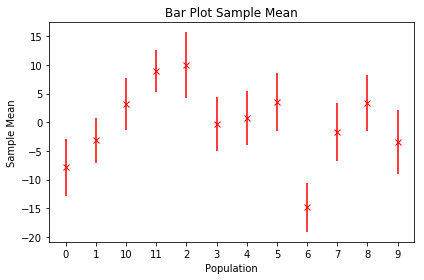

In [20]:
#4. 
import pandas as pd
import numpy as np
import math 
import re
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
#open file & read contents
f = open("./summary_large.txt")    
s = f.readlines()
line = str(s)

#Find Mean values in file
regex= re.compile(r"\s\-?\d+.\d+,")
keys = [] 
for x in regex.findall(line):
            keys.append(x)
#Remove spaces
regex2= re.compile(r"\-?\d+.\d+")

keys2=[]
for x in keys:
    p = regex2.findall(x)
    keys2.append(p)

#Remove commas 
key3= []
for x in keys2:
    flag=0
    temp = 0.0
    for y in x:
        #Negative
        if(y=='-'):
            flag=1
        temp = temp+float(y)
    if(flag==1):
        so = -1*float(temp)
        key3.append(so)
    else:
        so = float(temp)
        key3.append(so)

#Find Variance values in file
regex3= re.compile(r"\s\-?\d+.\d+]")
var= []
for x in regex3.findall(line):
    var.append(x)
    
#Remove spaces
regex4= re.compile(r"\-?\d+.\d+")
var2 = []
for x in var:
    p = regex4.findall(x)
    var2.append(p)
    

#Turn into float 
var3= []
for x in var2:
    flag=0
    temp = 0.0
    for y in x:
        #Negative
        if(y=='-'):
            flag=1
        temp = temp+float(y)
    if(flag==1):
        so = -1*float(temp)
        var3.append(so)
    else:
        #so = math.sqrt(float(temp))
        #var3.append(so)
        var3.append(float(temp))

#Find n
regex5= re.compile(r"[[]\d+")
n = [] 
for x in regex5.findall(line):
            n.append(x)
           
#Remove '['
regex6= re.compile(r"\d+")
n2 = [] 
for x in n:
    t= regex6.findall(x)
    n2.append(t)
    
#Convert to int
n3= []
for x in n2:
    for y in x:
        n3.append(int(y))

#Tags
objects = ("0","1","10","11","2","3","4","5","6","7","8","9")

#Plot
#z value for 95% CI ==> 1.96 [box plot seemed to require the actual data, choose errorbar]
plt.errorbar(objects, key3, yerr=1.96*np.sqrt(var3)/np.sqrt(n3), fmt='x', color= 'red')

#Graph info
plt.ylabel('Sample Mean')
plt.xlabel('Population')
plt.title('Bar Plot Sample Mean')

_= plt.tight_layout()

#Sava plot to  a pdf
fname= 'populations.pdf'
plt.savefig(fname, dpi=None, facecolor='w', edgecolor='w',orientation='portrait')

In [87]:
#Question 3
#1. 
from pyspark import SparkConf, SparkContext
import sys

# This script takes two arguments, an input and output
if len(sys.argv) != 3:
  print('Usage: ' + sys.argv[0] + ' <in> <out>')
  sys.exit(1)

inputlocation = sys.argv[1]
outputlocation = sys.argv[2]

# Set up the configuration and job context
conf = SparkConf().setAppName('magic')
sc = SparkContext(conf=conf)


# Read in the dataset and immediately transform all the lines in array
data= sc.textFile(inputlocation).map(lambda line: line.split())

#Find all possible combinations
def all_possible_friends(line):
    l2=[]
    for x in line[1:]:
        l2.append(int(x))
    
    t  = []
    n = (len(l2)-1)
    p = 1
    
    for x in range(len(l2)-1):
        c = p
        for y in range(n):
            
            #actual combinations
            komb0 = (int(line[0]),int(l2[x]),int(l2[c]))
            komb= (tuple(sorted(komb0)))
            map_komb= (komb,1)
            t.append(map_komb)
            c= c+1
        n = n-1
        p = p+1
    #print(sorted(t))    
    return t


#Map and reduce
data = data.flatMap(all_possible_friends)
data = data.reduceByKey(lambda x,y: x+y)

#Filter only friends with 2 edges (>1)
filter_data = data.filter(lambda x:x[1]>1)

#Map by key 
final_data = filter_data.map(lambda x:x[0])

#Save
final_data.saveAsTextFile(outputlocation)

#Terminate session
sc.stop()

ModuleNotFoundError: No module named 'pyspark'

In [149]:
# 2.
#Commands run
#spark-submit --master yarn --queue stats507 ps_fof.py hdfs:/var/stats507f19/fof/friends.simple smallfile

#hdfs dfs -cat smallfile/* > small_triangle_list.txt

#open file & read contents
f = open("./small_triangle_list.txt")    
s = f.readlines()
total = 0
for x in s:
    total +=1
#There are 4 triangles
#print(total)


4


  client token: Token { kind: YARN_CLIENT_TOKEN, service:  }
         diagnostics: AM container is launched, waiting for AM container to Register with RM
         ApplicationMaster host: N/A
         ApplicationMaster RPC port: -1
         queue: stats507
         start time: 1575502313081
         final status: UNDEFINED
         tracking URL: http://cavium-rm01.arc-ts.umich.edu:8088/proxy/application_1574565624302_2085/
         user: mzanaj
19/12/04 18:31:55 INFO yarn.Client: Application report for application_1574565624302_2085 (state: ACCEPTED)
19/12/04 18:31:56 INFO yarn.Client: Application report for application_1574565624302_2085 (state: ACCEPTED)
19/12/04 18:31:57 INFO yarn.Client: Application report for application_1574565624302_2085 (state: ACCEPTED)
19/12/04 18:31:58 INFO yarn.Client: Application report for application_1574565624302_2085 (state: ACCEPTED)
19/12/04 18:31:59 INFO yarn.Client: Application report for application_1574565624302_2085 (state: ACCEPTED)
19/12/04 18:32:00 INFO yarn.Client: Application report for application_1574565624302_2085 (state: ACCEPTED)
19/12/04 18:32:01 INFO yarn.Client: Application report for application_1574565624302_2085 (state: ACCEPTED)


In [2]:
#3. 
#Commands run
#spark-submit --master yarn --queue stats507 ps_fof.py hdfs:/var/stats507f19/fof/friends1000 bigfile

#hdfs dfs -cat bigfile/* > big_triangle_list.txt.txt

#open file & read contents
f = open("./big_triangle_list.txt")    
s = f.readlines()
total = 0
for x in s:
    total +=1
#There are 144120 triangles
#print(total)

144120
